In [ ]:
import pandas as pd
import joblib
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
pip install transformers==4.3.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.9 MB/s 
     |████████████████████████████████| 880 kB 54.7 MB/s 
     |████████████████████████████████| 3.3 MB 55.7 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=83f31350cb823dcdd54ab7e5d60f50f2bf08818d236abd8c9db594997e9e4c76
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
!pip install vncorenlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.6 MB 4.2 MB/s 
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645951 sha256=bb1b794afc6e5f091a94108a395fd9491e11eb2aa31304c0bd5816141791d64d
  Stored in directory: /root/.cache/pip/wheels/0c/d8/f2/d28d97379b4f6479bf51247c8dfd57fa00932fa7a74b6aab29
Successfully built vncorenlp


In [ ]:
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

--2022-06-13 17:26:40--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.1.1.jar’

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M   121MB/s    in 0.2s    

2022-06-13 17:26:41 (121 MB/s) - ‘VnCoreNLP-1.1.1.jar’ saved [27412575/27412575]

--2022-06-13 17:26:41--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respon

In [ ]:
train = pd.read_csv("/content/train.csv", index_col=False)
test = pd.read_csv("/content/test.csv", index_col=False)

In [ ]:
from vncorenlp import VnCoreNLP

vncorenlp = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')

In [ ]:
#pre-process
import re
import numpy as np

STOPWORDS = '/content/vietnamese-stopwords.txt'
with open(STOPWORDS, "r") as ins:
    stopwords = []
    for line in ins:  
        dd = line.strip('\n')
        stopwords.append(dd)
    stopwords = set(stopwords)

def filter_stop_words(train_sentences, stop_words):
    new_sent = [word for word in train_sentences.split() if word not in stop_words]
    train_sentences = ' '.join(new_sent)
        
    return train_sentences

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def preprocess(text, tokenized=True, lowercased=True):
    # text = ViTokenizer.tokenize(text)
    # text = ' '.join(vncorenlp.tokenize(text)[0])
    text = filter_stop_words(text, stopwords)
    text = deEmojify(text)
    text = text.lower() if lowercased else text
    if tokenized:
        pre_text = ""
        sentences = vncorenlp.tokenize(text)
        for sentence in sentences:
            pre_text += " ".join(sentence)
        text = pre_text
    return text

def pre_process_features(X, y, tokenized=True, lowercased=True):
    X = [preprocess(str(p), tokenized=tokenized, lowercased=lowercased) for p in list(X)]
    for idx, ele in enumerate(X):
        if not ele:
            np.delete(X, idx)
            np.delete(y, idx)
    return X, y

X_train = train['free_text']
y_train = train['label_id'].values

X_test = test['free_text']
y_test = test['label_id'].values

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

train_X, train_y = pre_process_features(X_train, y_train, tokenized=True, lowercased = False)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=True, lowercased = False)

In [ ]:
test_X

['Đừng cố biện_minh = ) ) ) ) choi lon',
 'Haizz .Nthe dân khổ',
 'the ma chi phat gay roi trat tu cong_cong thoi a dung la dan_minh',
 'Mua hộp bcs mĩ sài oai : ) )',
 'coin card : 3',
 'K dừng hả trời ☹️☹️☹️',
 ': ) )',
 'Chi_Chui',
 'Lê_Văn_Quật vid',
 'Lý khùng có , kk',
 'À Nhật chẳng hợn Võ_Hồng_Tâm',
 'Thầy trêu lắm r',
 'Ôi thơ',
 'hang luc nao cung phai chuan nhu hom giao toi day nhe',
 'Lee_Shung_Liem yep yep . chỗ e',
 'set đồ vận_động_viên tết vff quản_lý tiền thưởng',
 'Thay_Ngu',
 'Đc đấy abe',
 'Hóng 2 hài hải_ngoại Ba Lasvegas',
 'Sét đánh chết tao đi',
 'Amen khoẻ Idol tui',
 'Chị gia giàu khổ giúp đi Sài tiền tiệm vàng Sài',
 '( Y ) page ad kiến_thức uyên sâu lắm xây_dựng tài y_tế j n am = ) ) ) ) ngu_dốt + nhiệt_tình = phá_hoại k sai bh',
 'Đề_nghị 17 , 22,23,32 phà hơi mẹt tk đi ly giới hẳn đi .',
 'Nhà Xa trường_học , cầu_tiêu câu gắn sâu đầu tao : ) ) ) ) )',
 'A n vl',
 'Hoàng_Yến fan cứng độ mixi đi lẩu phan = ) ) ) ) ) ) ) ) ) ) ) )',
 'From_Bình_Phước < 3',
 '

In [ ]:
train_X

['Em fan cứng nè ❤️ reaction cute coi mấy hợp_lí = ] ] ]',
 'Đúng bọn mắt híp lò_xo thụt : ) ) ) việt_nam t 10 r bọn t gọi L : ) ) )',
 'Đậu_Văn_Cường thằng sida',
 'CÔN_ĐỒ CỤC_SÚC VÔ_NHÂN TÍNH ĐỀ NGHI VN .NHÀ_NƯỚC VN BAN THƯỞNG .',
 'Từ lý_thuyết thực_hành 1 câu = ) )',
 'Coronavirus is manmade',
 'Đố m',
 'Lúp lúp chó .',
 '🥰🥰🥰',
 'Thế mấy thằng bắc kì , bọn bâu vô phân_biệt !: D',
 'Được ưi , phúc du rap 🤣',
 'Cắt trẻ trâu bớt thui',
 'Nghe vô_lí cực_kì thuyết_phục',
 'chán ghê hong pé 2 máu được , hâhha',
 'Sao t gửi đc bây',
 'đấy . j bọn nó . bọn quyền j chả : v',
 'Loại dựa cột độ',
 'Thuong wa di',
 'Dạy bơi cá .Bơi đương_nhiên bơi cá .Làm sống dân quan_tâm .',
 'Ủa bữa lỗi khóc tế om xòm chửi bó hỗn',
 'Bamtp chạy ddi : ) )',
 'Cứ đăng ảnh 2 bố y đổi',
 'Dàn_Táo chương_trình TÁO_QUÂN VI_HÀNH mn , phát_sóng 9h tối 23 Tết VTV3 : ) )',
 'Thật chán chế_độ quản_lý dân_sinh',
 'Đời vô lắm .. sống tu tâm tích đức oi .. khẩu nghiệp',
 'được , đồng_đội , đồng_chí , hữu đơn_vị ảnh không

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vectorizer = CountVectorizer()
train_X = vectorizer.fit_transform(train_X)
test_X = vectorizer.transform(test_X)

In [ ]:
train_X.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(train_X,train_y)

MultinomialNB()

In [ ]:
y_predict = model.predict(test_X)

[[5384    8  156]
 [ 310   35   99]
 [ 348   10  330]]
F1 - micro: 0.86062874251497
F1 - macro: 0.5294607302294443
Accuracy: 0.86062874251497


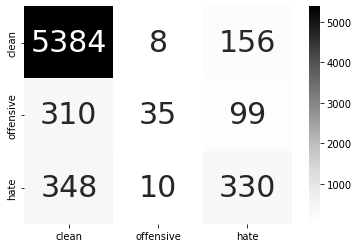

In [ ]:
cf1 = confusion_matrix(test_y, y_predict)
print(cf1)

evaluation = f1_score(test_y, y_predict, average='micro')
print("F1 - micro: " + str(evaluation))

evaluation = f1_score(test_y, y_predict, average='macro')
print("F1 - macro: " + str(evaluation))

evaluation = accuracy_score(test_y, y_predict)
print("Accuracy: " + str(evaluation))

# Show out the confusion matrix
df_cm1 = pd.DataFrame(cf1, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

In [ ]:
#Đưa vector dự đoán label vào dataframe
df_predict = pd.DataFrame(y_predict)
df_predict.columns = ['predict']

In [ ]:
#Nối cột predcit vào test
df_test_predict = test.join(df_predict)
df_test_predict

,free_text,label_id,predict
0,Đừng cố biện minh =)))) choi lon,0,2
1,Haizz. Nthe này thì dân khổ quá,1,0
2,the nay ma chi phat gay roi trat tu cong cong ...,0,0
3,Mua cho em hộp bcs mĩ sài cho oai :)),0,0
4,coin card :3,1,0
...,...,...,...
6675,Nghe cũng được. Nhưng vẫn cày views,0,0
6676,Pha team up căng cực đến từ vị trí ông chủ đầm...,0,0
6677,Thanh Nhường sao m đọc đc cmt của t thế tiên s...,0,0
6678,"Đúng rồi, nhìn có ria mép , với mặt giống đàn ...",0,0


In [ ]:
#xem các dự đoán sai
df_test_predict.query('label_id != predict')

,free_text,label_id,predict
0,Đừng cố biện minh =)))) choi lon,0,2
1,Haizz. Nthe này thì dân khổ quá,1,0
4,coin card :3,1,0
16,Thay Ngu,2,0
23,"Đề nghị 17, 22,23,32 đến phà vài hơi vào mẹt t...",2,0
...,...,...,...
6659,Cám ơn đảng. Cám ơn nhà nc 😏,2,0
6660,Khẩu nghiệp quá. Con cháu nghe xấu hổ chết.,1,2
6670,"Tôi không dùng bảo hiểm , bởi vì bác sĩ coi th...",2,0
6672,vãi l =)),1,0


In [ ]:
len(df_test_predict.query('label_id != predict'))

931